In [2]:
from PyUoI.UoINMF import UoINMF
from activ import load_data, data_normalization
import os
from activ.readfile import TrackTBIFile
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import numpy as np
from activ.analytics import heatmap, nmf_bases_heatmap
from activ.clustering import UmapClusteringResults
from os.path import dirname, join
from scipy.optimize import curve_fit
from scipy.stats import norm, sem
from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import display, Latex, Markdown
from pylatex import Document, Section, Subsection, Command
from pylatex import Document, Section, Figure, SubFigure, NoEscape
from pylatex.utils import italic, NoEscape
from scipy.stats import norm, sem

/Users/ahyeon/anaconda3/envs/activ/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
def conf_alliter(size, predicted, actual):
    confalliter = []
    for j in range(50):
        conf = np.zeros((size,size))
        labs = list(map(int, actual[j][size-2]))
        preds = list(map(int, predicted[j][size-2]))
        for l, p in zip(labs, preds):
            conf[l,p] += 1
        confalliter.append(conf)
    return confalliter

In [4]:
def statistics(matrix):
    mat = np.matrix(matrix)
    i = mat.shape[0]-2
    tp = mat[i,i]
    tn = mat.sum() - mat[i,:].sum() - mat[:,i].sum() + mat[i,i]
    fp = mat[:,i].sum() - mat[i,i]
    fn = mat[i,:].sum() - mat[i,i]
    return tp, tn, fp, fn

In [5]:
def accuracy(mat):
    return mat.trace()/mat.sum()

def specificity(tn, fp):
    return tn/(tn+fp)

def sensitivity(tp, fn):
    return tp/(tp+fn)

def fscore(tp, fp, fn):
    return (2*tp)/(2*tp+fp+fn)

No handles with labels found to put in legend.


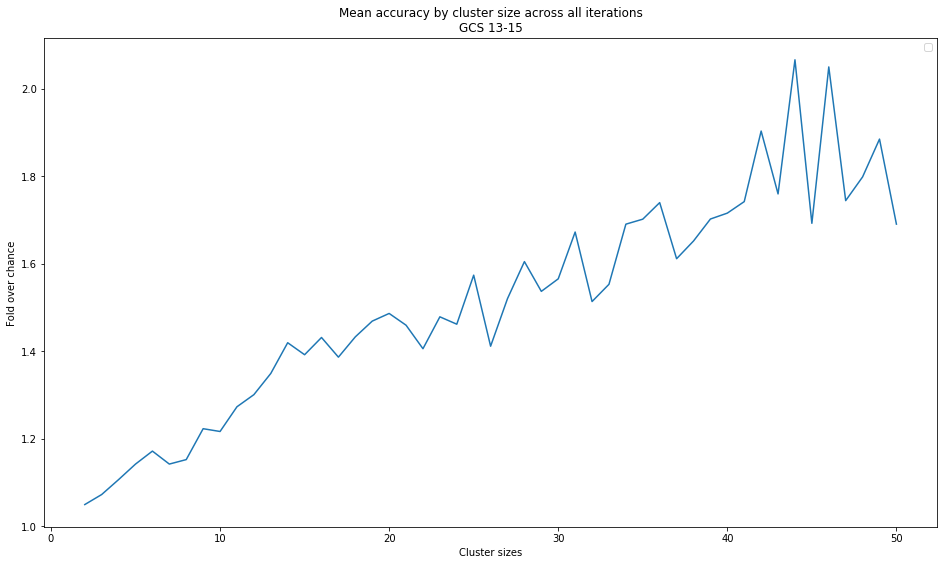

In [16]:
path = '/Users/ahyeon/Desktop/activ/results/gcs13-15/dim_10_gcs13-15_results.h5'
f = h5py.File(path, 'r')
predictions = np.squeeze(f['score'][:], axis=1)
norm_predictions = np.squeeze(f['norm_score'][:], axis=1)
cluster_sizes = f['cluster_sizes'][:]
labels = np.squeeze(f['clusters'][:], axis=1)
fold_over_chance = np.zeros((len(cluster_sizes), 50))
for jj,c in enumerate(cluster_sizes):
    all50mat = conf_alliter(c, predictions, labels)
    norm_all50mat = conf_alliter(c, norm_predictions, labels)
    acc = [accuracy(i) for i in all50mat]
    norm_acc = [accuracy(i) for i in norm_all50mat]
    foc = [float(x/y) for x, y in zip(acc, norm_acc)]
    fold_over_chance[jj,:] = foc
fold_over_chance = np.mean(fold_over_chance, axis=1)

plt.rcParams["figure.figsize"] = [16,9]
cmap = plt.get_cmap("tab10")
plt.plot(cluster_sizes, fold_over_chance)

plt.title("Mean accuracy by cluster size across all iterations\nGCS 13-15")
plt.xlabel("Cluster sizes")
plt.ylabel("Fold over chance")
plt.legend()
plt.savefig('/Users/ahyeon/Desktop/activ misc/gcs13-15.pdf')